In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

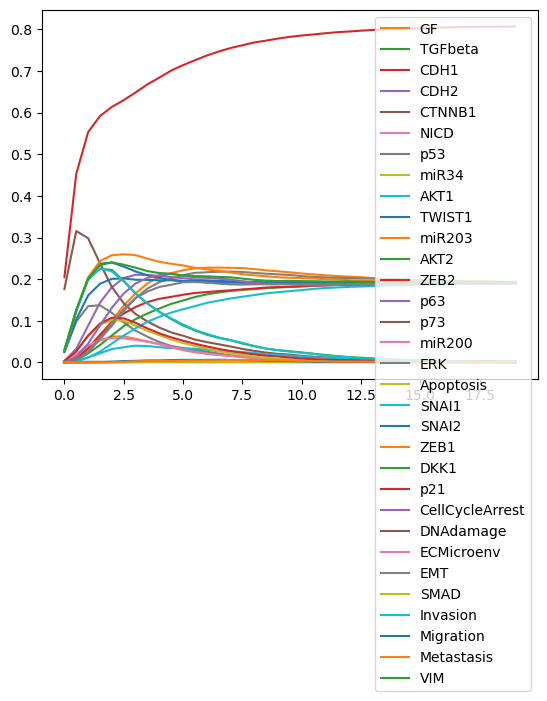

In [2]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/Invasion/Invasion_0.bnet')
model.update_parameters(max_time = 20)
simulation = model.run()
simulation.plot_node_trajectory()

model_nodes = model.network.names

In [12]:
# Create blank file to get the results
ensemble_results = {}

path = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/' 
model_list = os.listdir(path)

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at random
    for i in simulations.network.names:
        simulations.network.set_istate(i,[0.5,0.5])
        
    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_new.csv')

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [50:14<00:00,  2.94s/it]


In [3]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_new.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [4]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

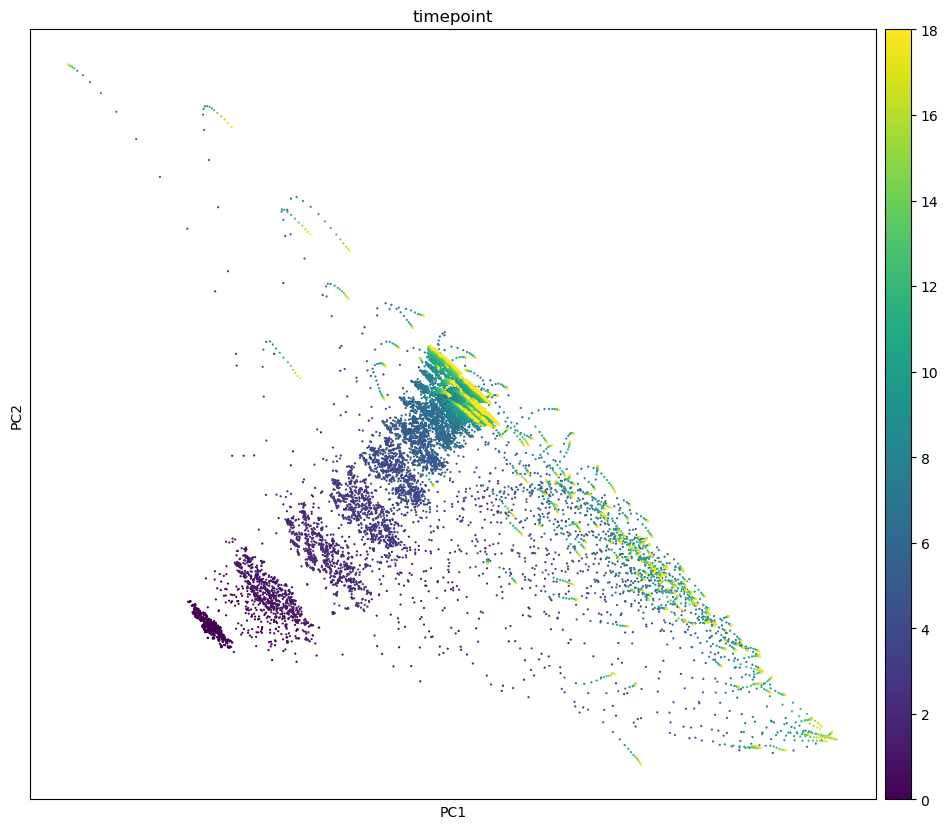

In [6]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')

# plot 
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 10)

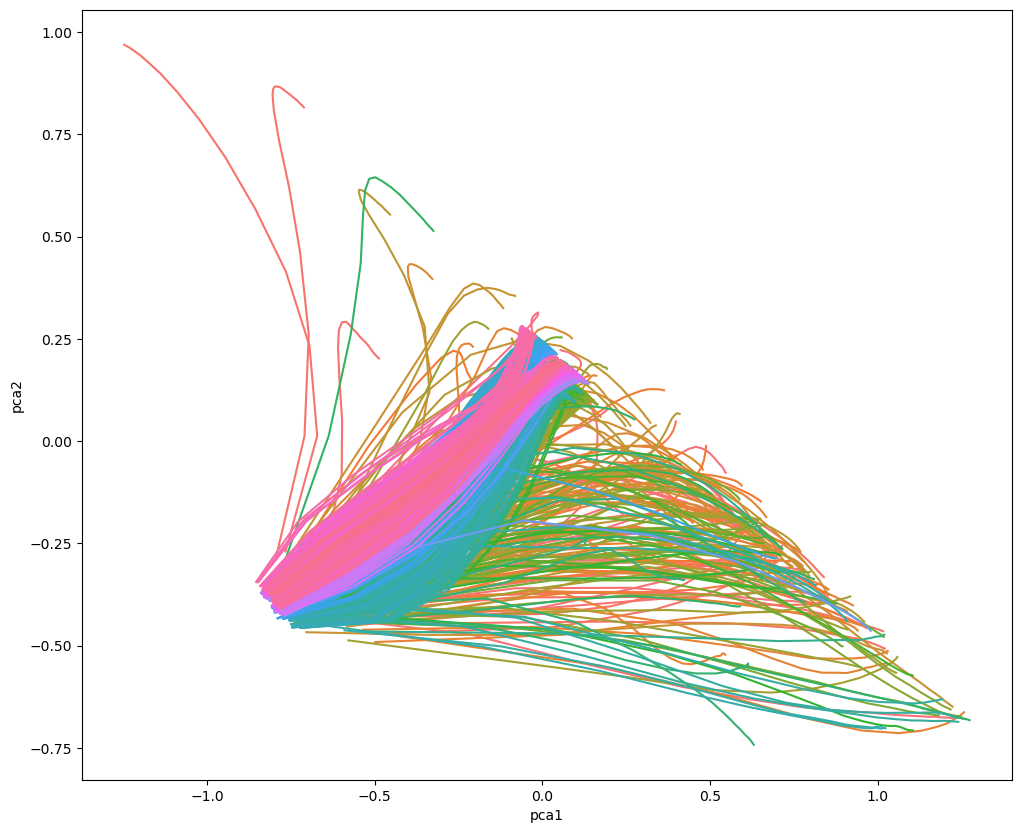

In [7]:
# Convert the PCA position to timeseries data
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

# plot
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, x = 'pca1',y='pca2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

# Trajectory comparison using single variable from PCA

In [8]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.105 --> 0.091 --> 0.086 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 


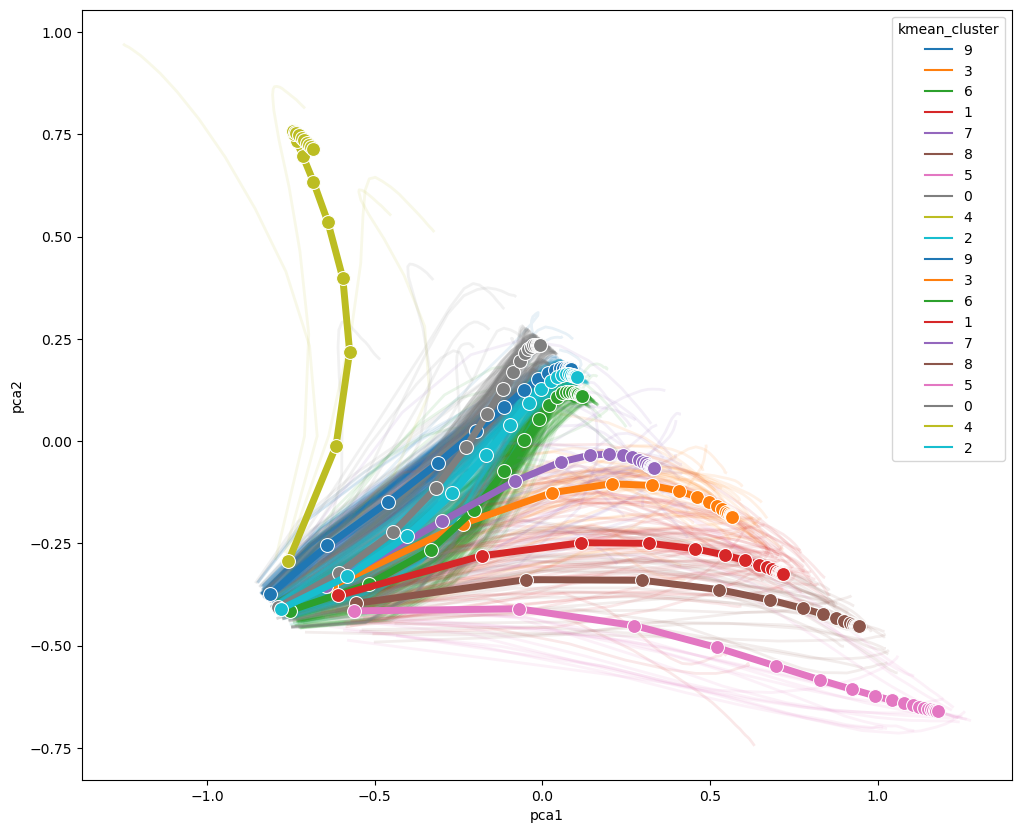

In [9]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


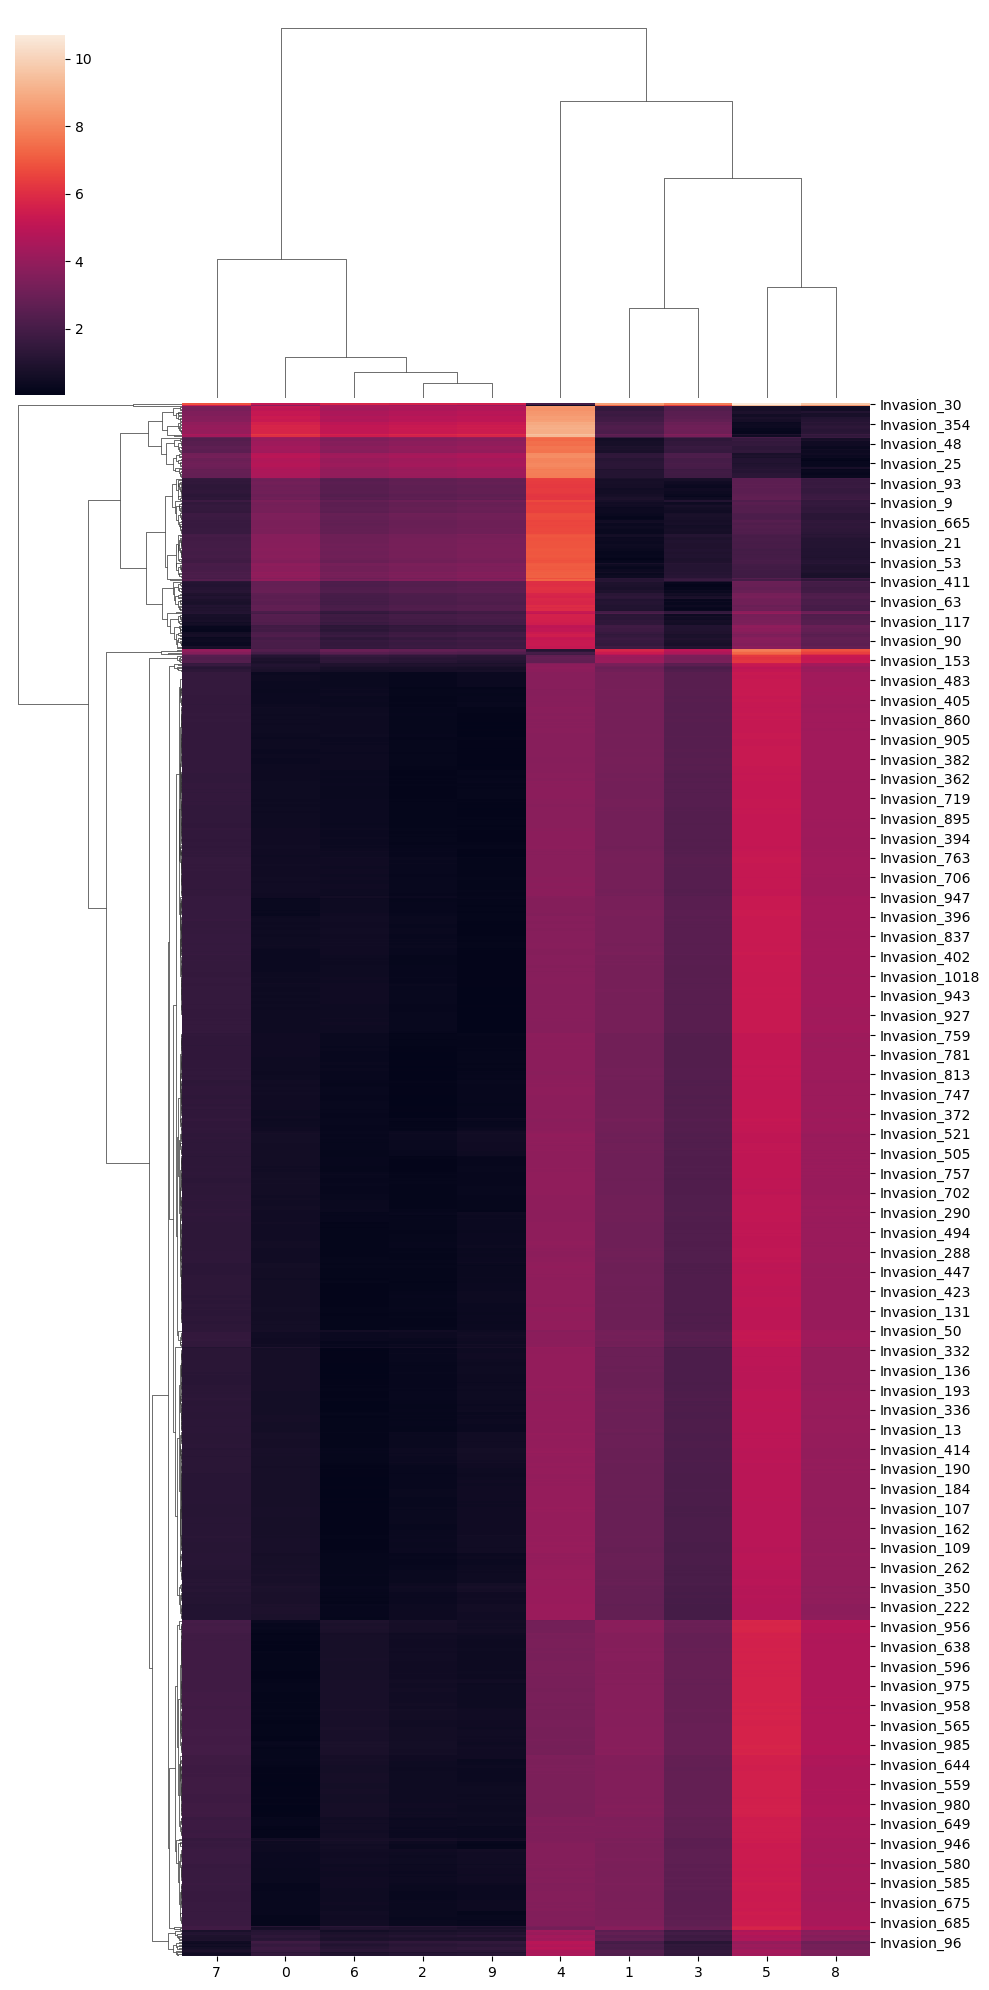

In [20]:
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
distance_space.index = list(model_pca_all.keys())

sns.clustermap(distance_space, figsize = (10,20))

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


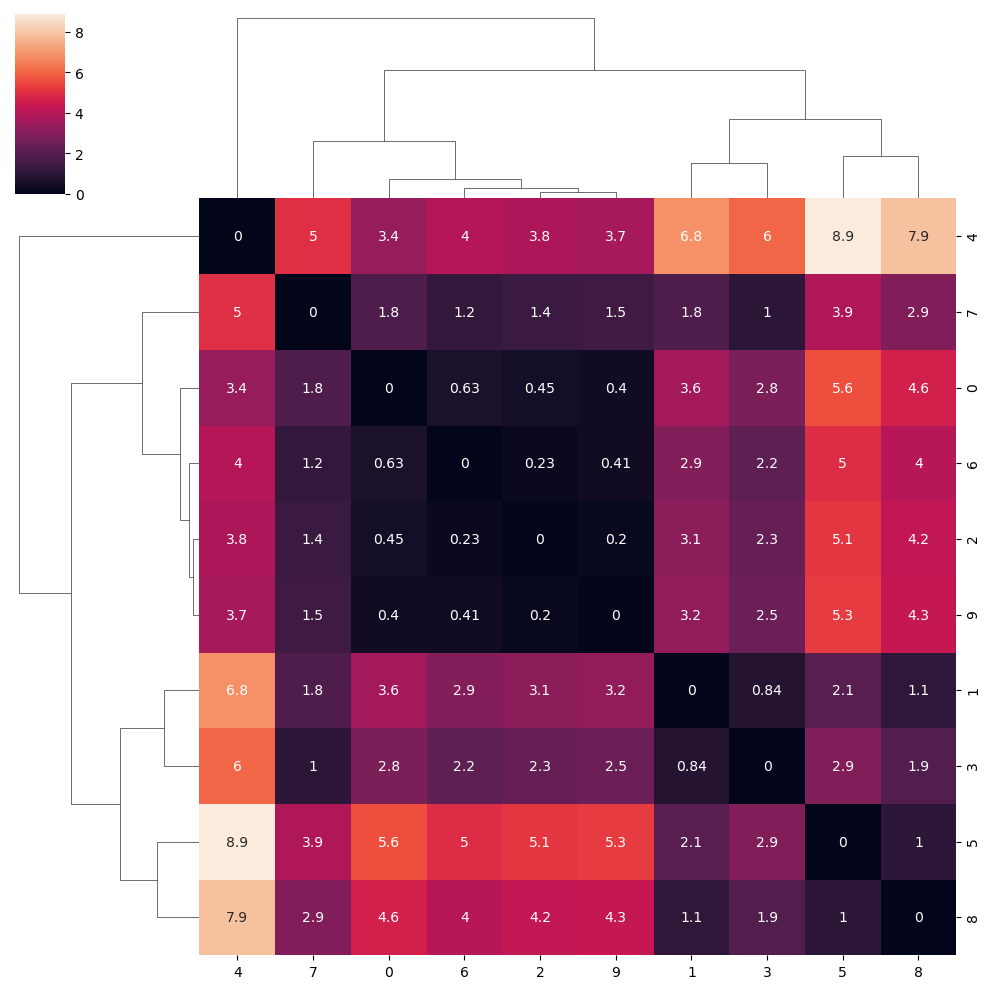

In [21]:
# Compact data into the right format
kmean_cluster = pca_mat.groupby(['kmean_cluster','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in list(range(10)):
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in list(range(10)):
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = list(range(10))

# Plot Euclidean distance using clustermap
sns.clustermap(distance_matrix, annot=True)

plt.show()

['Invasion_0',
 'Invasion_1',
 'Invasion_2',
 'Invasion_3',
 'Invasion_4',
 'Invasion_5',
 'Invasion_6',
 'Invasion_7',
 'Invasion_8',
 'Invasion_9',
 'Invasion_10',
 'Invasion_11',
 'Invasion_12',
 'Invasion_13',
 'Invasion_14',
 'Invasion_15',
 'Invasion_16',
 'Invasion_17',
 'Invasion_18',
 'Invasion_19',
 'Invasion_20',
 'Invasion_21',
 'Invasion_22',
 'Invasion_23',
 'Invasion_24',
 'Invasion_25',
 'Invasion_26',
 'Invasion_27',
 'Invasion_28',
 'Invasion_29',
 'Invasion_30',
 'Invasion_31',
 'Invasion_32',
 'Invasion_33',
 'Invasion_34',
 'Invasion_35',
 'Invasion_36',
 'Invasion_37',
 'Invasion_38',
 'Invasion_39',
 'Invasion_40',
 'Invasion_41',
 'Invasion_42',
 'Invasion_43',
 'Invasion_44',
 'Invasion_45',
 'Invasion_46',
 'Invasion_47',
 'Invasion_48',
 'Invasion_49',
 'Invasion_50',
 'Invasion_51',
 'Invasion_52',
 'Invasion_53',
 'Invasion_54',
 'Invasion_55',
 'Invasion_56',
 'Invasion_57',
 'Invasion_58',
 'Invasion_59',
 'Invasion_60',
 'Invasion_61',
 'Invasion_62',
 '

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, me

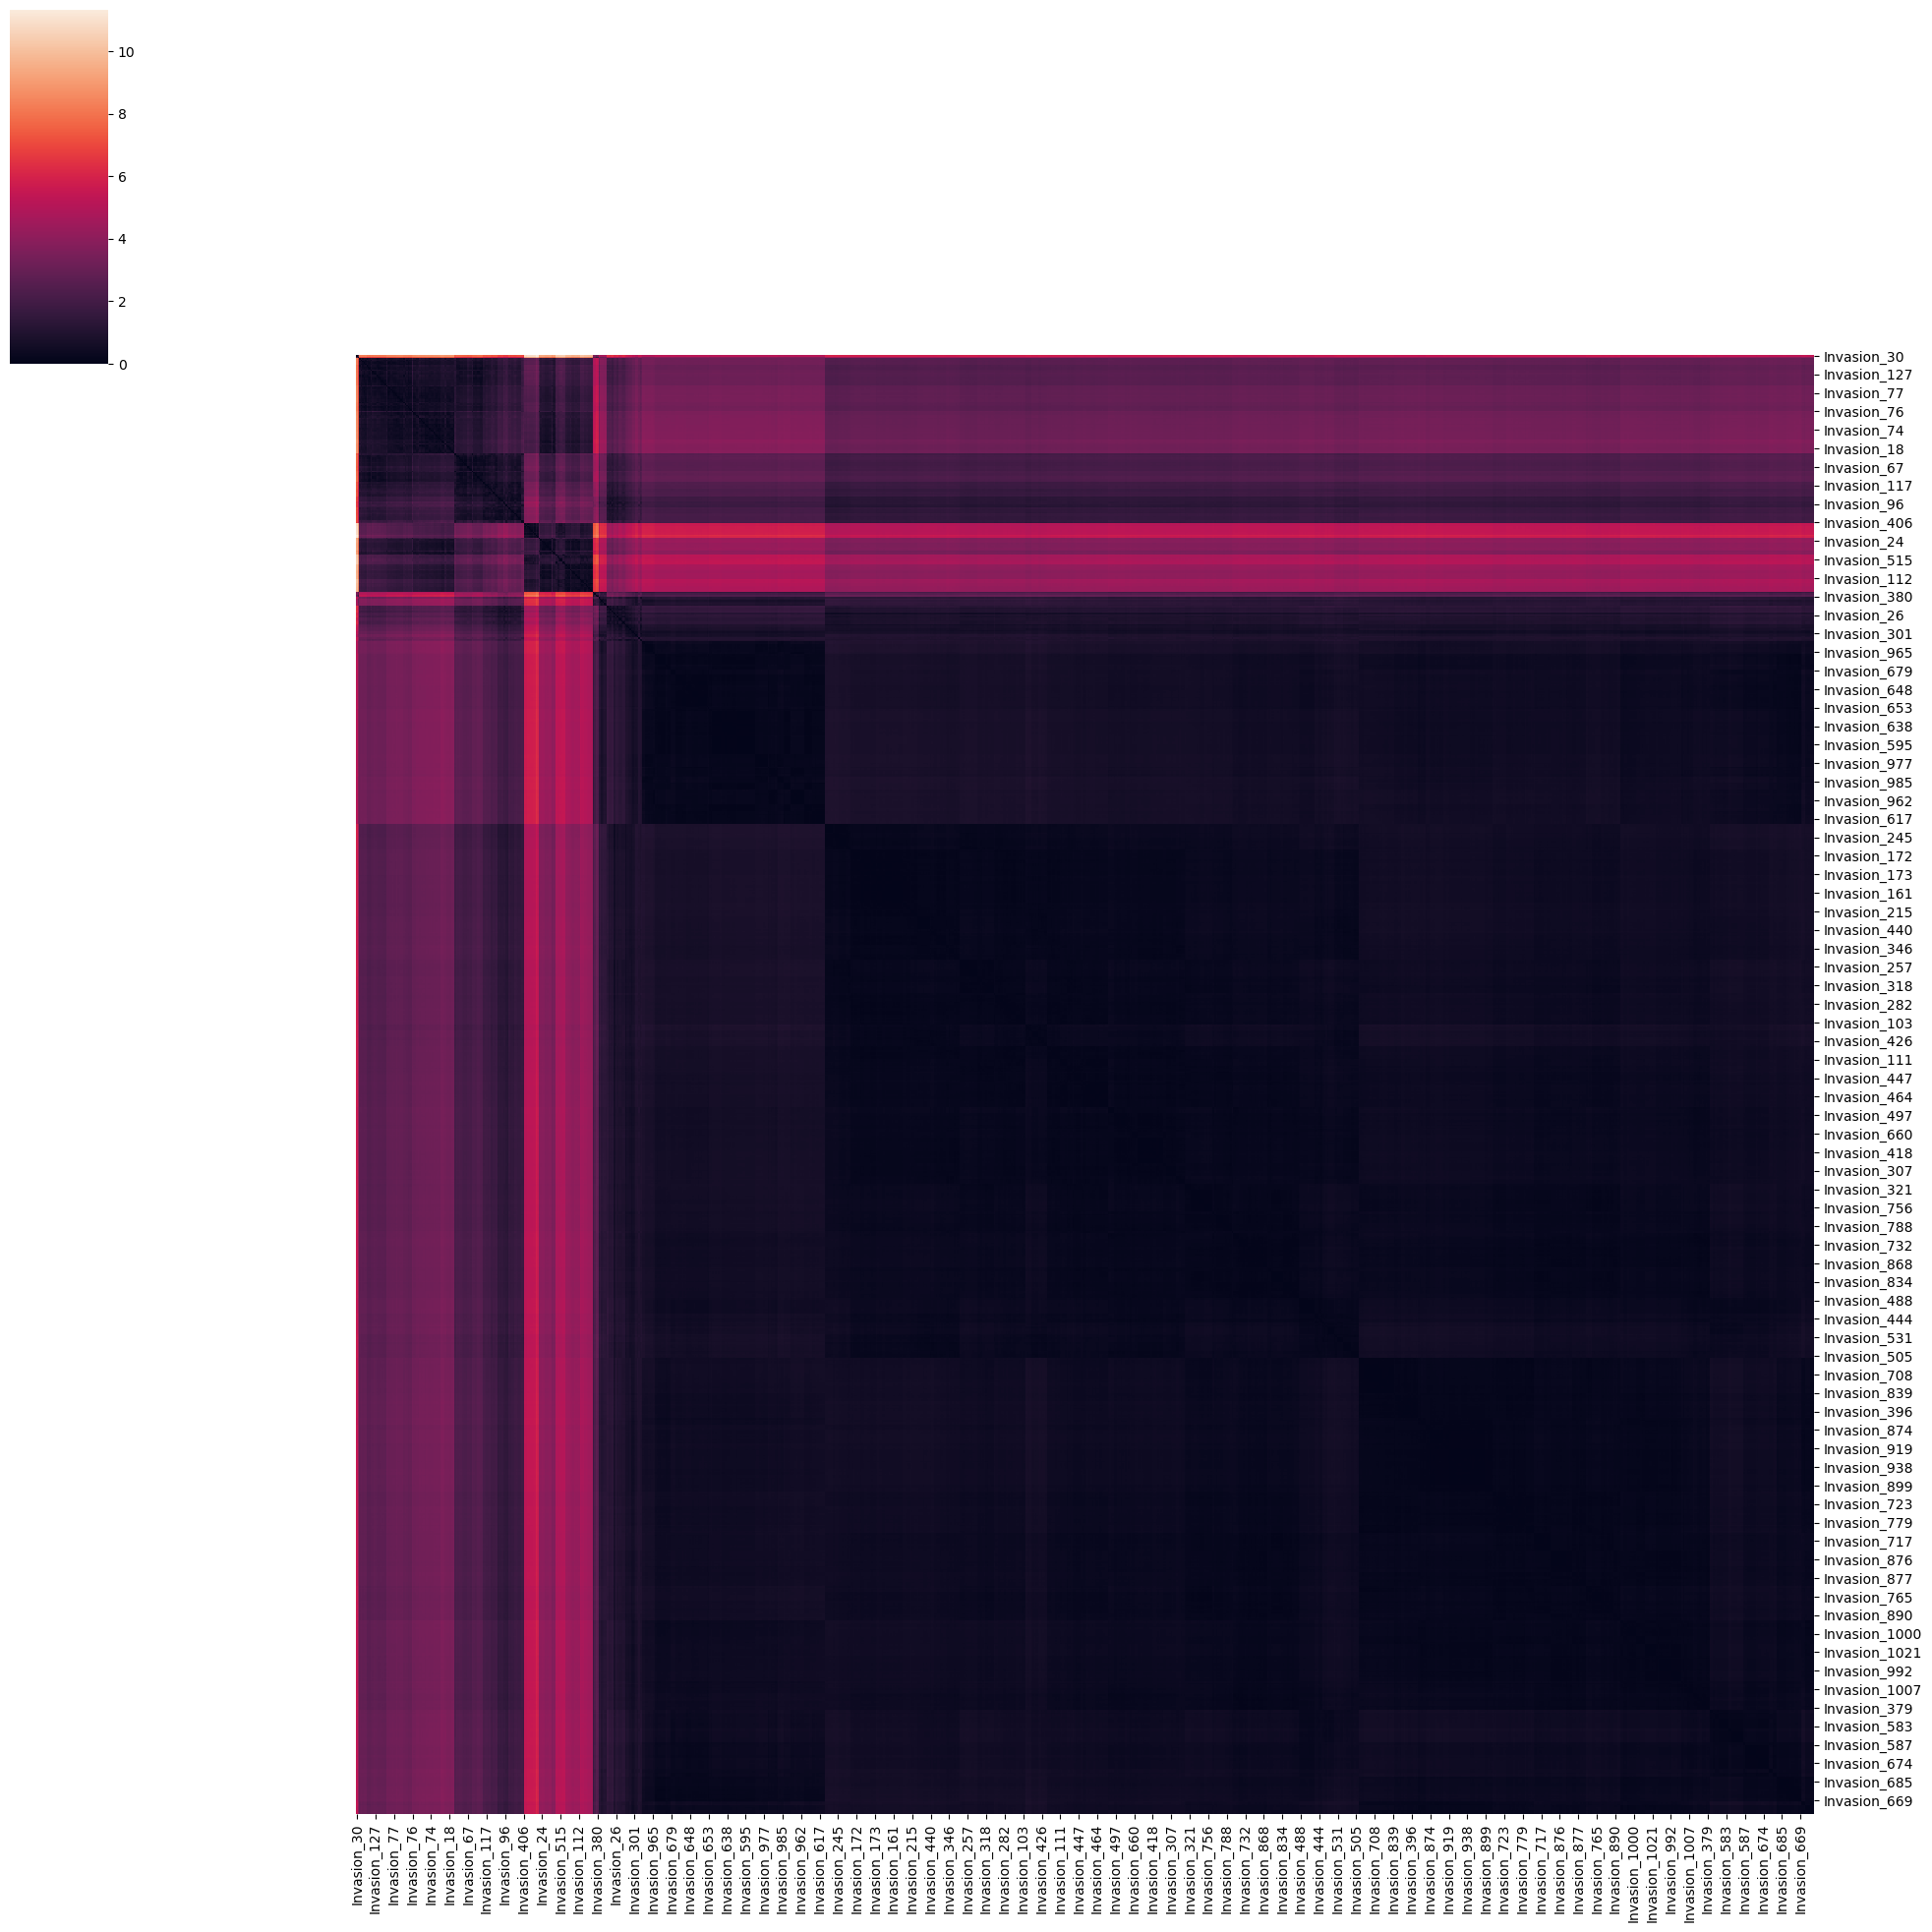

In [49]:
# Get model_id
model_id = list(cluster_dict.keys())

# Compact data into the right format
kmean_cluster = pca_mat.groupby(['model_id','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in model_id:
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in model_id:
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = model_id
distance_matrix.index = model_id

# Plot Euclidean distance using clustermap
g = sns.clustermap(distance_matrix, figsize = (20,20))

# Hiding the row dendrogram
g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
g.ax_col_dendrogram.set_visible(False)

plt.show()

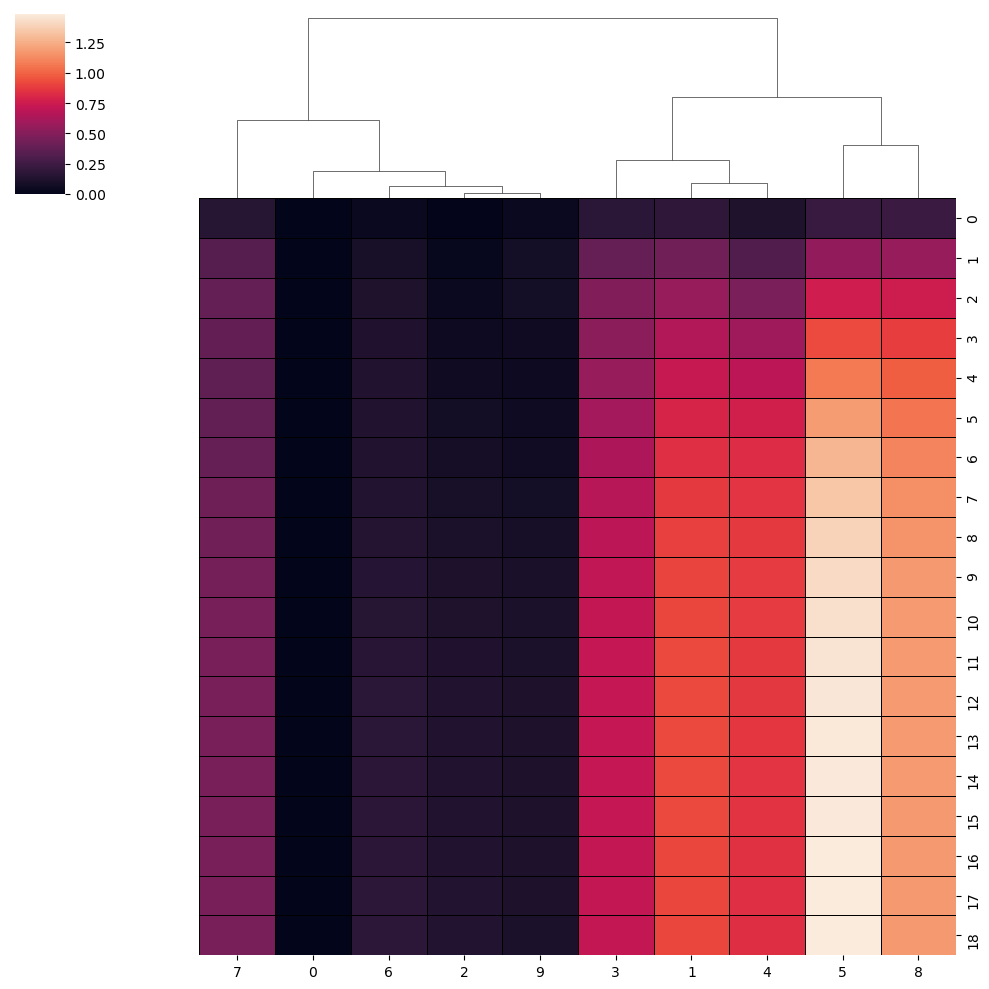

In [23]:
time_series1 = numpy.array(kmean_cluster.loc[0])
cluster_distance = pd.DataFrame()

for i in list(range(10)):
    time_series2 = numpy.array(kmean_cluster.loc[i])

    distance = pd.DataFrame(((time_series1 - time_series2))**2)
    distance = numpy.sqrt(distance[0] + distance[1])
    cluster_distance = pd.concat([cluster_distance,distance], axis = 1)
cluster_distance.columns = list(range(10))

sns.clustermap(cluster_distance, row_cluster=False, linewidth = .5, linecolor = 'black')

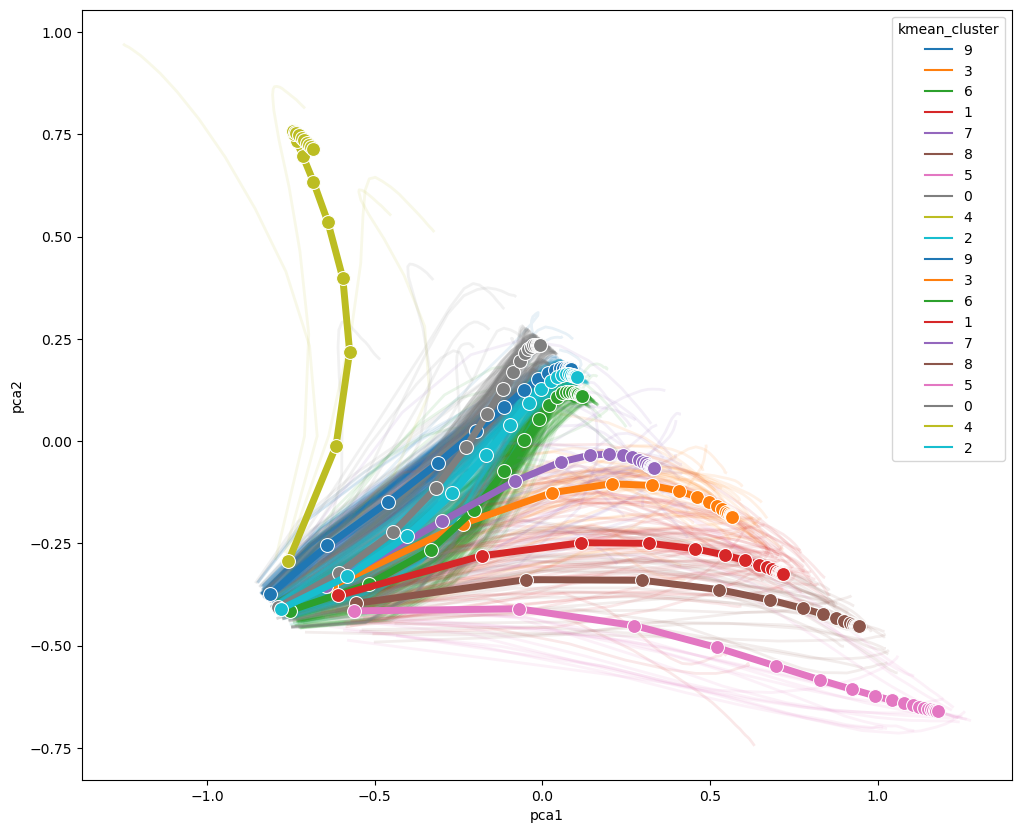

In [162]:
## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [50]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

In [68]:
cpal = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


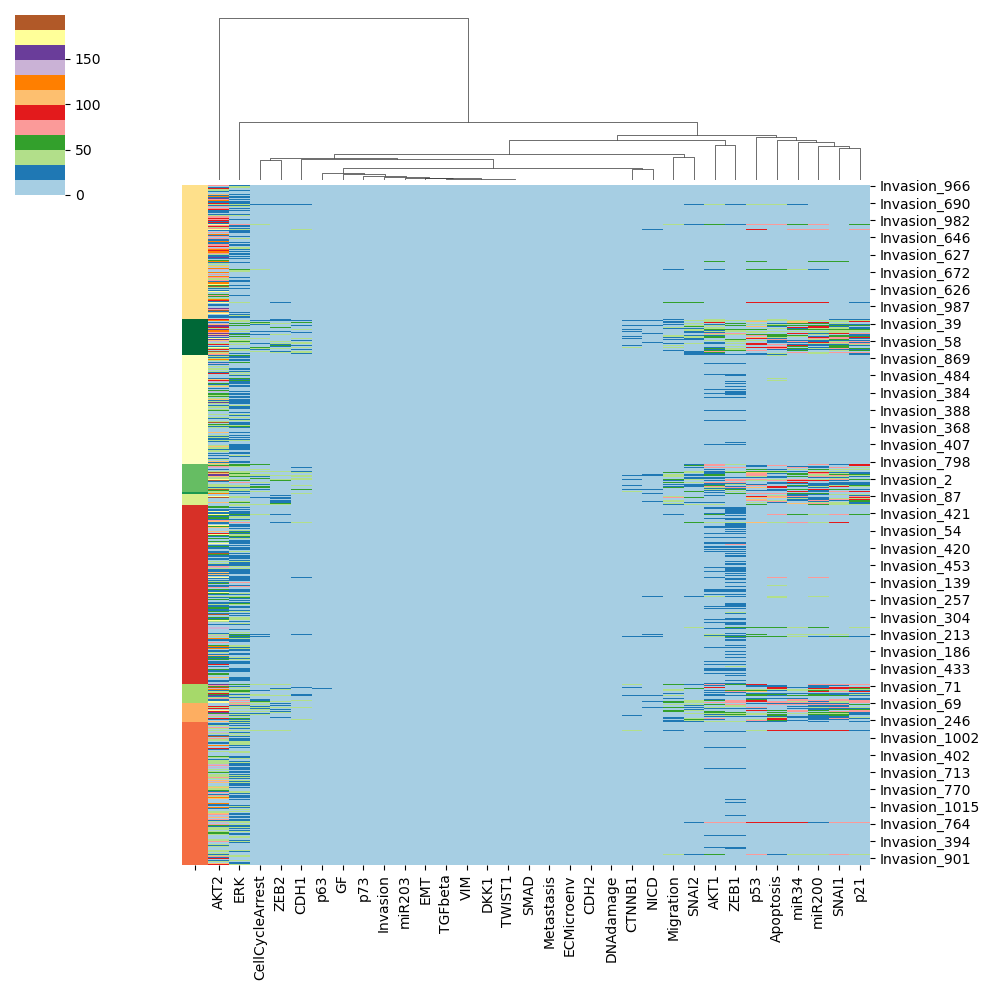

In [73]:
model_logic_categorical = model_logic.copy()
for i in model_logic_categorical.columns:
    model_logic_categorical[i], _ = pd.factorize(model_logic[i])



# Create cluster color palette
kmean_index = pd.Series(model_logic.index, index = model_logic.index)
kmean_index = kmean_index.replace(cluster_dict)
lut = dict(zip(kmean_index.unique(), cpal))
row_colors = kmean_index.map(lut)

sort_index = list(kmean_index.sort_values().index)

# Plot clustermap
sns.clustermap(model_logic_categorical.loc[sort_index],
            row_colors = row_colors[sort_index], 
            row_cluster=False,
            col_cluster = True,
            cmap = 'Paired')

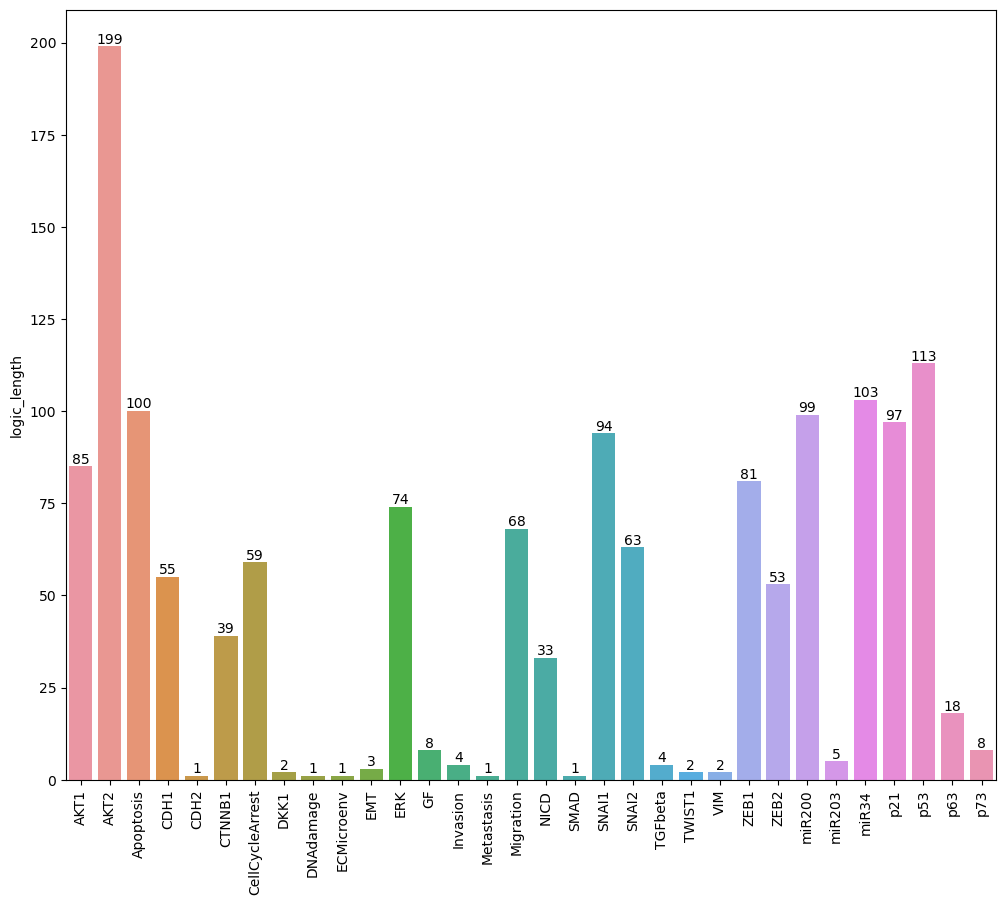

In [72]:
var_logic_length = []
for i in model_logic.columns:
    num_logic = model_logic[i].value_counts().size
    var_logic_length.append(num_logic)
var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic.columns)

with rc_context({"figure.figsize": (12, 10)}):
    ax = sns.barplot(x = var_logic_length.index, 
                y = var_logic_length.logic_length)
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xticks(rotation = 90)
plt.show()